  # Test of multiclass classifier
## (with g-r color and non-detections)

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier

  ### Definition of names for plots and files

In [2]:
date = '20190925'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v3/labels.pkl'
detections_file = '../alerce_trainingset/training_set_v3/detections.pkl'
#features_file = '../alerce_trainingset/training_set_v3/features.pkl'
features_file = '../ZTF_data/features_20190926.pickle'
non_detections_file = '../alerce_trainingset/training_set_v3/training_non_det_v3.h5'
augmentation_dir = '../alerce_trainingset/short_sne_training_set/'

early_probs = '../ZTF_data/stamps_old.pkl'

gaia_parallax = '../ZTF_data/gaia_parallaxes.csv'



#where the RF models are saved
model_file = 'stat_multiclassRF/rf_model_multiclass_'+date

#confusion matrixes
conf_matrix_name = 'stat_multiclassRF/confusion_matrix_rf_model_multiclass_'+date

#feature importances
feature_importance_name = 'stat_multiclassRF/feature_importance_rf_model_multiclass_'+date


### reading the training set files 


In [3]:
df_nd = pd.read_hdf(non_detections_file)
df_feat = pd.read_pickle(features_file)
df_labels = pd.read_pickle(labels_file)
df_detections = pd.read_pickle(detections_file)

df_early_probs = pd.read_pickle(early_probs)

df_gaia_parallax = pd.read_csv(gaia_parallax,index_col='oid')


#deleting columns in df_nd with name ending in "_3"
#for col in list(df_nd):
#    if col[-2:] == "_3":
#        df_nd.drop(col, inplace=True, axis=1)

#getting gscore from the detections file
#df_det = df_detections.groupby(['oid'])
#df_sgscore = df_det['sgscore1'].median()
#df_sgscore = df_sgscore.to_frame()

#creating color features
#df_nd["g_r_max"] = df_nd.min_mag_fid_1 - df_nd.min_mag_fid_2
#df_feat["g_r_mean"] = df_feat.Mean_1 - df_feat.Mean_2

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

df_early_probs.head()

,AGN,SN,VS,asteroid,bogus
ZTF18abbktxw,0.022929,0.000022,0.973655,0.000029,3.364119e-03
ZTF18abndukk,0.007837,0.000013,0.990255,0.000001,1.893446e-03
ZTF18aaxyuzy,0.061182,0.000008,0.935789,0.000006,3.014782e-03
ZTF18abjaayi,0.064645,0.000003,0.929185,0.000005,6.161781e-03
ZTF18abptzkt,0.974924,0.000137,0.024876,0.000062,6.631693e-07


In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'

#defining the classes included in the RF model
label_order = ['AGN-I', 'Blazar', 'CV/Nova', 'LPV', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'RS-CVn', 'Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''

#combining all the DF
#df = labels.join(df_sgscore).join(df_feat).join(df_nd.drop(rm_nd_cols, axis=1))
#df = labels.join(df_sgscore).join(df_feat.drop(rm_nd_cols, axis=1))
df = labels.join(df_early_probs).join(df_feat.drop(rm_nd_cols, axis=1))
df_train = df
df_train.fillna(-999,inplace=True)
df.drop(['Mean_1', 'Mean_2','class_original','VS','SN','asteroid','bogus'], axis=1, inplace=True)
df.fillna(-999,inplace=True)
labels = labels.loc[df.index.values]
'''
if morethan5:
    df = df[(df.n_samples_1 > 5) & (df.n_samples_2 > 5)]
    labels = labels.loc[df.index.values]
'''
df.head()

,AGN,delta_mag_fid_1,delta_mag_fid_2,delta_mjd_fid_1,delta_mjd_fid_2,dmag_first_det_fid_1,dmag_first_det_fid_2,dmag_non_det_fid_1,dmag_non_det_fid_2,g-r_max,...,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,GP_DRW_sigma_2,GP_DRW_tau_2,IAR_phi_2,LinearTrend_2,gal_b,gal_l
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aacjwvd,0.022542,0.424199,0.378390,271.098183,308.101134,2.543534,2.714242,2.939435,3.789690,0.917404,...,1.000000,9.320852e-05,0.241617,0.002623,2.522917e-02,0.255101,0.000084,0.000277,20.470856,185.723835
ZTF17aadecrr,0.001370,0.935824,0.491198,347.994942,304.160069,5.238234,-999.000000,5.504596,-999.000000,0.964960,...,1.000000,1.113585e-04,0.249795,0.102750,2.051202e-02,0.620047,0.187446,0.000486,-8.541295,190.823524
ZTF18adaksvf,0.016643,0.229270,0.600738,113.687512,192.702361,2.992945,4.185538,3.222215,4.412964,0.876349,...,1.000000,1.268727e-04,0.200540,-0.118095,2.028384e-02,0.525963,0.029509,-0.000960,64.283014,275.075197
ZTF18abtqdih,0.001980,0.355823,0.210677,376.014641,381.944410,6.048240,-999.000000,5.901356,-999.000000,0.630459,...,0.231151,-3.693538e-05,0.000000,0.000000,5.421010e-08,0.642937,0.513844,-0.000073,-33.524393,127.583847
ZTF18abshynt,0.834363,0.000000,0.096107,0.000000,127.756667,2.004425,3.774174,2.004425,4.262174,2.506249,...,0.700503,-9.363979e-08,0.000000,0.000000,1.302898e-09,1.001022,0.001090,0.000237,13.026900,9.935559


  ### Defining functions to plot the confusion matrix and the feature importance


In [6]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [7]:
Y_training = labels['class_original']#.values

X_training = df#.columns.values.tolist()

#splitting training set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_training,
                                Y_training, test_size=0.3, stratify=Y_training)


 ## Balanced random forest

In [8]:
#Training the RF model
rf_model = RandomForestClassifier(n_estimators=500,#500
        max_features='auto',
        max_depth=None,
        n_jobs=8,
        class_weight='balanced_subsample',
        criterion='entropy',
        min_samples_split=2,
        min_samples_leaf=1)

rf_model.fit(X_train, y_train)

#testing model performance

y_true, y_pred = y_test, rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_list = list(X_training)

with open(model_file, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model,
            'features': features_list,
            }
        pickle.dump(model_dump, pickle_file)

Accuracy: 0.5852463443805702
Balanced accuracy: 0.5892075569458378


[[2563  284   15   16    2   10    9   57    3    4    6   16   12   12
    14]
 [  70  113   27    8    2    2    1    4    1    1    4    4    1    1
    11]
 [  11   10  145    5   12    7    2    4    1    4   10    4    6    2
     9]
 [ 167   59   13 5702   29   79    9   66    1    4   34    0  191  367
   141]
 [   0    0    0    1  131   52    9   15    0    0    0    0    0    0
     0]
 [   0    0    0    0    3    9    1    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    7   13   28    7    0    0    0    0    0    0
     1]
 [   0    0    0    0    0    1    1    4    0    0    0    0    0    0
     0]
 [ 272   67  119   13    0    1    0   16 2022 1362  788  331  363 1386
  1000]
 [  56   15   64    5    1    0    0    5  360  622  195  109  140  279
   233]
 [  11    0    0    0    0    0    0    0    6    7  126   30    3   11
    11]
 [ 107   34   34    4    1    0    0   18   88   42  458 3387  144   77
   356]
 [   3    3    4    5    0    0    0    

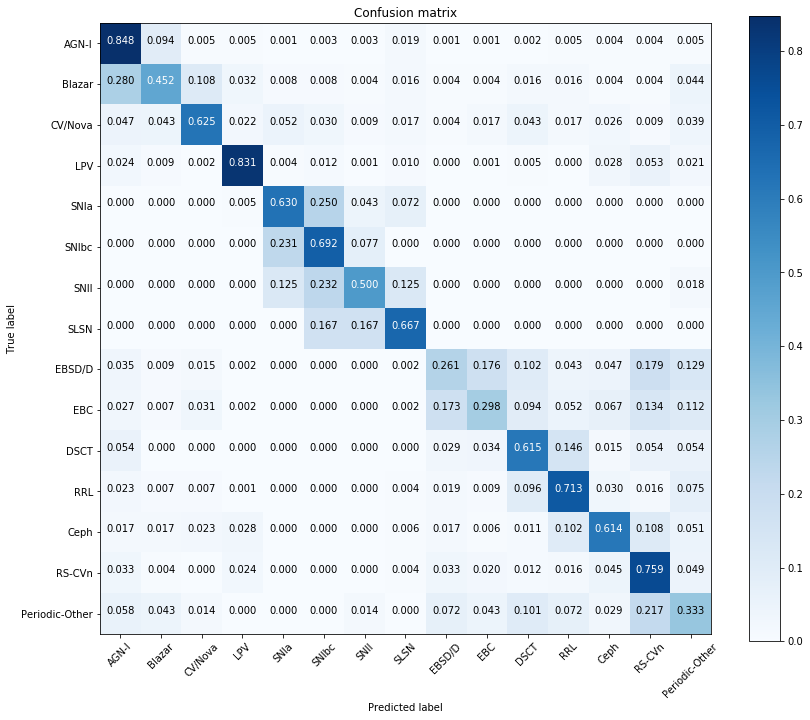

In [9]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order,conf_matrix_name)

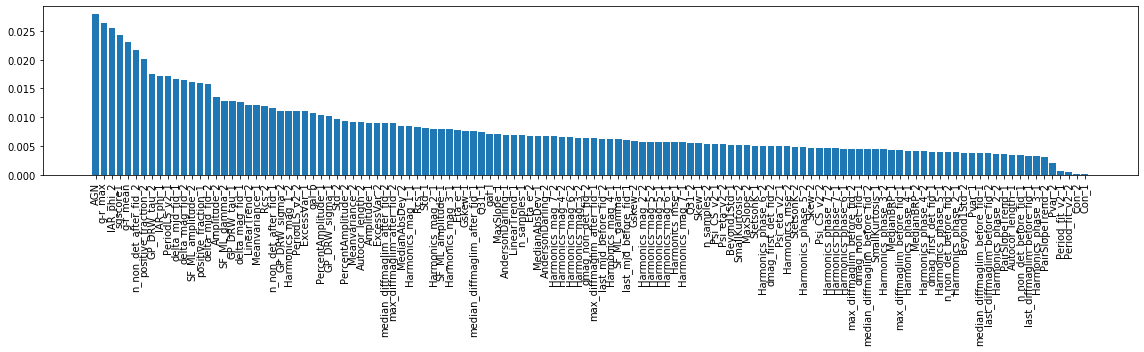

In [10]:
#plotting feature importance
plot_feature_importances(rf_model, features_list, feature_importance_name)

In [11]:
# Kaggle score

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(Y_training)
num_y_test = label_encoder.transform(y_test)

CLASSES_REDUCED_V2 = label_encoder.inverse_transform(np.arange(len(label_order)))

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,y_pred_proba))

AGN-I -0.08177100646730462
Blazar -0.12192961490514602
CV/Nova -0.1130576547381644
Ceph -0.10854060962300796
DSCT -0.10577345463068649
EBC -0.12684807026723222
EBSD/D -0.12660931153151564
LPV -0.09222056927846238
Periodic-Other -0.1324778019895018
RRL -0.10210548082805676
RS-CVn -0.10524247883774751
SLSN -0.09840418079797908
SNII -0.10344246990734436
SNIa -0.08625905294107027
SNIbc -0.08370789460676759
1.588389651349987
